# Projeto 3
### por: Gabriel Pizzighini, Pedro Azambuja, Luigi Corradi


# Como podemos utilizar análises probabilisticas para tirar conclusões sobre futuros ataques terroristas na Europa?

#### importando blibiotecas 

In [2]:
import plotly as py
from plotly.graph_objs import*
import pandas as pd
py.offline.init_notebook_mode(connected=True)

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets.species_distributions import construct_grids
from sklearn.datasets import fetch_species_distributions
from sklearn.cluster import KMeans
from matplotlib import style
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
import seaborn as sns
import ipywidgets as widgets

#### Importando o Database

In [4]:
dt = pd.read_csv("globalterrorismd.csv", encoding ='latin1')
dt.head()

C:\Users\Luigi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning:

Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.



,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


#### Limpando o dataframe

In [5]:
# lipando o Database
dt = dt.loc[:, ['iyear','imonth','iday','country','gname',
'country_txt',
'region_txt',
'region',
'city',
'latitude',
'longitude',
'success',
'attacktype1',
'attacktype1_txt',
'targtype1',
'targtype1_txt',
'targsubtype1',
'targsubtype1_txt',
 'weaptype1',
 'weaptype1_txt',
 'weapsubtype1',
 'weapsubtype1_txt',
 'weaptype2',
 'weaptype2_txt',
 'weapsubtype2',
 'weapsubtype2_txt',
 'nkill',
 'nwound',]]
dt= dt[(dt.region_txt=="Eastern Europe")|(dt.region_txt=="Western Europe")]
dt = dt[dt.iyear >= 2000]
#dt = dt[dt.country_txt != 'Russia']
dt.nkill = dt.nkill.fillna(0)
dt.nwound = dt.nwound.fillna(0)


### Calculando probabilidades condicionais de P(pais|ataque) por meio do .groupby()


In [6]:
ataques = []
for i in dt.attacktype1_txt:
    if i not in ataques:
        ataques.append(i)

paises = []
for i in dt.country_txt:
    if i not in paises:
        paises.append(i)

In [7]:

# calculando P(pais|ataque)
dt2 = dt.loc[:,['attacktype1_txt', 'country_txt']]
#achando P(ataque)
p_ataque = dt2.groupby('attacktype1_txt').size().div(len(dt2))
#achando P(pais|ataque)
dt3 = dt2.groupby(['country_txt','attacktype1_txt']).size().div(len(dt2)).div(p_ataque, axis=0, level='attacktype1_txt')

In [8]:
# #criando dicionario contendo todas possiveis probabilidades
dict_p ={}
for i in ataques:
    dict_p[i] = {}
    for k in paises:
        if i not in dt3[k]:
            dict_p[i][k] = 0 #o groupby nao apresenta os valores nulos, por isso estamos adicionando de novo
        else:
            dict_p[i][k] = dt3[k][i] 


In [9]:
df = pd.read_csv('all.csv') # obtendo os codigos ISO para plotar pelo plotly
df.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150.0,154.0
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150.0,39.0
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,2.0,15.0
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,9.0,61.0


#### Adicionando códigos aos países para serem interpretados pelo plotly

In [10]:
#transformando o dicionario em DataFrame
colo_colum = pd.DataFrame(dict_p)
paises = colo_colum.index
p_codes = []

#Loop que atribui o código ISO de cada país de accordo com valores oficiais
for i in range(len(df)):
    for e in paises:
        if e == df.loc[i][0]:
            p_codes.append(df.loc[i][1])
            
#Manualmente atribuindo códigos a países sem ISO oficial
p_codes = ['ALB', 'AUT', 'BLR', 'BEL','BIH', 'BGR', 'HRV',
           'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU',
           'GRC', 'HUN', 'ISL', 'IRL', 'ITA','RKS', 'LVA',
           'MKD', 'MLT','MDA', 'MNE', 'NLD', 'NOR', 'POL',
           'PRT', 'ROU','RUS', 'SRB','SCG','SVK', 'SVN',
           'ESP', 'SWE', 'CHE', 'UKR','GBR']

#Retirando a yugoslavia
colo_colum = colo_colum.iloc[:-1]

#Criando coluna : "CODE"
colo_colum["CODE"] = p_codes
colo_colum

,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,Unknown,CODE
Albania,0.000000,0.003546,0.002932,0.000000,0.000000,0.000000,0.005882,0.009615,0.000000,ALB
Austria,0.001467,0.000000,0.000000,0.014300,0.000000,0.000000,0.000000,0.009615,0.000000,AUT
Belarus,0.000000,0.000000,0.001599,0.002043,0.000000,0.000000,0.000000,0.009615,0.000000,BLR
Belgium,0.002201,0.000000,0.001333,0.006129,0.000000,0.000000,0.000000,0.076923,0.000000,BEL
Bosnia-Herzegovina,0.003668,0.010638,0.005330,0.003064,0.000000,0.000000,0.000000,0.009615,0.010526,BIH
Bulgaria,0.000000,0.007092,0.002932,0.002043,0.000000,0.000000,0.000000,0.019231,0.000000,BGR
Croatia,0.000000,0.003546,0.002665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,HRV
Cyprus,0.000000,0.003546,0.006130,0.001021,0.000000,0.000000,0.000000,0.000000,0.000000,CYP
Czech Republic,0.000000,0.003546,0.001866,0.006129,0.000000,0.000000,0.000000,0.038462,0.000000,CZE
Denmark,0.002935,0.003546,0.000267,0.002043,0.000000,0.000000,0.000000,0.000000,0.000000,DNK


### Graficos para analise:
#### Plotando os mapas da Europa em função de P(pais|ataque) para o ataque escolhido

In [11]:
a = widgets.Dropdown(
    options = ataques,
    
    value = ataques[0],
    description='Selecione o Tipo de Ataque:',
    disabled=False,
)
a

In [14]:
coluna_escolhida = a.value
if coluna_escolhida in ataques:
    #Implementação do plotly
    data = [ dict(
        type = 'choropleth',
        locations = colo_colum['CODE'], # codigo dos Paises 
        z = colo_colum[coluna_escolhida], #Tipo de ataque
        text = colo_colum.index,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '- ',
            title = 'Probability'),
      ) ]

    layout = dict( # mudança no layout do mapa
        title = 'Terrorism for {0}(2000-2015)'.format(coluna_escolhida),
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict( data=data, layout=layout ) #importando dicionarios para o plotly
    py.offline.iplot( fig, validate=False, filename='d3-world-map' )


## Classificador Multinomial Naive Bayes

<p>Imagine se pudesse antecipar o alvo de um ataque terrorista a partir de outros parametros do mesmo atentado?

<p> Pois bem, tentaremos realizar esse feito por meio de um classificador multinomial Naive Bayes, e utilizando como entrada três dados, sendo eles o país, o tipo de ataque e o tipo arma usada, representados em nossos dados por country_txt, attacktype1_txt, weaptype1_txt, respectivamente.

<p> Vejamos o quão confiavel nossa análise pode ser em relação à essa predição


In [11]:
#Filtrando novamente a base de dados
dt_1 = pd.read_csv("globalterrorismd.csv", encoding ='latin1', low_memory = False)
dt_2= dt_1[((dt_1.region_txt=="Eastern Europe")|(dt_1.region_txt=="Western Europe"))&(dt_1.iyear >= 2000)&(dt_1.targtype1_txt !="Unknown")&(dt_1.targtype1_txt !="Other")&(dt_1.targtype1_txt !="Food or Watter Supply")&(dt_1.targtype1_txt !="Maritime")]
dt_2 = dt_2.loc[:,['country_txt', 'attacktype1_txt','weaptype1_txt','targtype1_txt']]
dt_2.targtype1_txt.value_counts()
#mostrando os tipos de alvos

Private Citizens & Property       1446
Military                          1106
Police                            1039
Government (General)               892
Business                           800
Transportation                     295
Religious Figures/Institutions     267
Government (Diplomatic)            135
Journalists & Media                126
Utilities                           76
Educational Institution             74
NGO                                 32
Telecommunication                   31
Airports & Aircraft                 25
Terrorists/Non-State Militia        24
Tourists                            20
Violent Political Party             15
Food or Water Supply                 5
Name: targtype1_txt, dtype: int64

In [12]:
#reorganizando o dataframe aleatoriamente
dt_novo = dt_2.sample(len(dt_2))


In [13]:
#criando uma coluna de valor numerico para cada tipo de alvo existente no dataframe
label_dict ={}
valor = 0
for i in range(len(dt_novo)):
    if dt_novo['targtype1_txt'].iloc[i] not in label_dict:
        label_dict[dt_novo['targtype1_txt'].iloc[i]] = valor
        valor+=1
dt_novo['label_num'] = dt_novo.targtype1_txt.map(label_dict)
dt_novo.head()


,country_txt,attacktype1_txt,weaptype1_txt,targtype1_txt,label_num
78501,France,Bombing/Explosion,Explosives/Bombs/Dynamite,Private Citizens & Property,0
95440,United Kingdom,Bombing/Explosion,Explosives/Bombs/Dynamite,Police,1
142608,Ukraine,Bombing/Explosion,Explosives/Bombs/Dynamite,Private Citizens & Property,0
125210,Greece,Facility/Infrastructure Attack,Incendiary,Government (General),2
100488,Russia,Bombing/Explosion,Explosives/Bombs/Dynamite,Government (General),2


In [14]:
#criando diferentes dataframes para treinamento, teste e resultado esperado(target)
dt_learn = dt_novo.loc[:,['attacktype1_txt','weaptype1_txt','country_txt']]
dt_treinamento = dt_learn.head(int(len(dt_novo)/2)) #dividindo dataframe em dois
dt_teste = dt_learn.tail(int(len(dt_novo)/2))

dt_target = dt_novo.loc[:,['targtype1_txt', 'label_num']]
dt_targ_train = dt_target.head(int(len(dt_novo)/2))
dt_targ_test = dt_target.tail(int(len(dt_novo)/2))

In [15]:
#como MultinomialNB do sklearn tem como input matrizes e array temos que transformar nosso dataframe no formato certo
#no caso do (y) tambem chamado de target, deve ser um array unidimensional
train_target = np.asarray(dt_targ_train.label_num)
test_target = np.asarray(dt_targ_test.label_num)

In [16]:
#no caso dos dados de aprendizado, tanto treinamento (X),quanto teste, no nosso caso sao variaveis categoricas 
#e primeiro vamos tranforma-las em um dicionario para entao vetoriza-las em matrizes
DICTvec = DictVectorizer(sparse=True, dtype=int)
#cada linha do dataframe sera um dicionario dentro de uma lista
train_data =[]
for k, i, j in zip(dt_treinamento['attacktype1_txt'], dt_treinamento['weaptype1_txt'],dt_treinamento['country_txt']):
    train_data.append({'attacktype1_txt': k, 'weaptype1_txt': i, 'country_txt': j})
train_data   
Train_data = DICTvec.fit_transform(train_data)

In [17]:
#fazendo o mesmo para os dados de teste
test_data =[]
for k, i, j in zip(dt_teste['attacktype1_txt'], dt_teste['weaptype1_txt'],dt_teste['country_txt']):
    test_data.append({'attacktype1_txt': k, 'weaptype1_txt': i, 'country_txt': j})

Test_data = DICTvec.transform(test_data)

In [18]:
#testando se os nossos vetores tem a mesma dimensao
Train_data.shape[0] == train_target.shape[0]

True

In [19]:
Test_data.shape[0] == test_target.shape[0]

True

In [20]:
#implementando o sklearn.naivebayes.MultinomialNB
NB = MultinomialNB()
NB.fit(Train_data,train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
#classificando o nosso dataframe de teste
resultado = NB.predict(Test_data)

In [26]:
#calculando % de acerto
acerto = metrics.accuracy_score(test_target,resultado)
print("Multinomial Naive Bayes apresentou uma porcentagem de acerto de: {:0.2f}%".format(acerto*100))

print('Caso fosse escolhido um alvo aleatorio probabilidade de acerto seria de:{:0.2f}%'.format(1/len(label_dict)*100))

Multinomial Naive Bayes apresentou uma porcentagem de acerto de: 40.51%
Caso fosse escolhido um alvo aleatorio probabilidade de acerto seria de:5.56%


Como podemos observar compararando a porcentagem de acerto com e a change de um acerto aleatorio, o Naive Bayes mostrou um bom desempenho na hora de classficar os alvos de um atentado terrorista em função do país, tipo de ataque e tipo de arma. 
Mesmo com um desempenho satisfatorio, o classificador ainda se confunde, variando a quantidades de acerto de alvo para alvo, o que pode ser melhor observado por uma confusion matrix

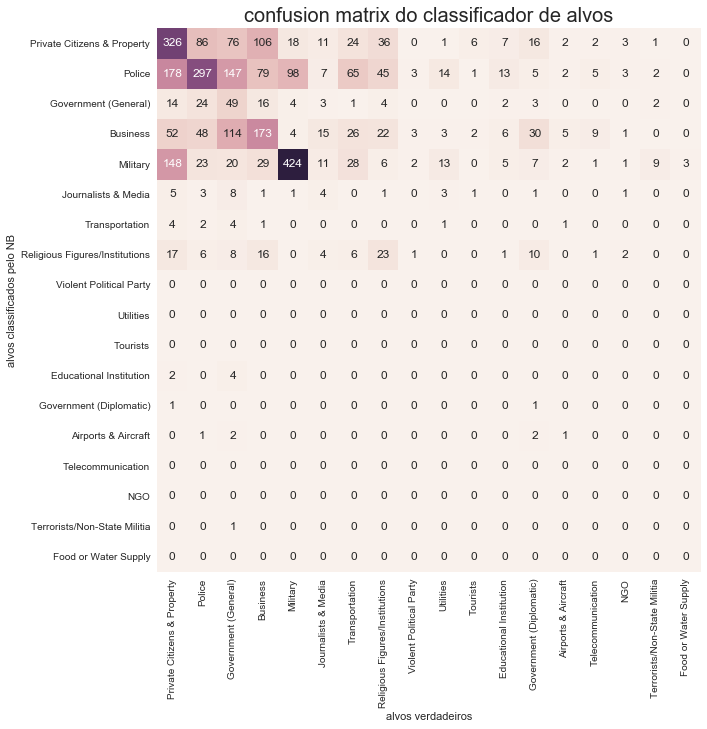

In [27]:
#plotando um heatmap da confusion matrix no classificador multinomial
mat = metrics.confusion_matrix(test_target,resultado)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(label_dict.keys()), yticklabels=list(label_dict.keys()))
plt.title('confusion matrix do classificador de alvos',fontsize = 20)
plt.xlabel('alvos verdadeiros')
plt.ylabel('alvos classificados pelo NB');
plt.show()


O heatmap plotado acima, mostra as intersecções entre oque o naive bayes classificou e seus valores reais, se o classificador fosse perfeito, nao teria nenhuma confusao e todos os dados estariam certos, logo o heat map teria uma faixa escura em sua diagonal. como o acerto é de aproximadamente 40% podemos observar areas mais escuras em valores errados, e tipos de alvos no qual nao houve nenhum acerto